### libs

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [2]:
import lightgbm as lgb

In [3]:
import sklearn as sk

In [34]:
import shap

### data

In [4]:
import seaborn as sns

df = sns.load_dataset("titanic")
print(f"{df.shape = }")
print(df.head().to_string())

df.shape = (891, 15)
   survived  pclass     sex   age  sibsp  parch     fare embarked  class    who  adult_male deck  embark_town alive  alone
0         0       3    male  22.0      1      0   7.2500        S  Third    man        True  NaN  Southampton    no  False
1         1       1  female  38.0      1      0  71.2833        C  First  woman       False    C    Cherbourg   yes  False
2         1       3  female  26.0      0      0   7.9250        S  Third  woman       False  NaN  Southampton   yes   True
3         1       1  female  35.0      1      0  53.1000        S  First  woman       False    C  Southampton   yes  False
4         0       3    male  35.0      0      0   8.0500        S  Third    man        True  NaN  Southampton    no   True


### features

In [5]:
### basic

In [6]:
cols = df.columns.tolist()

In [7]:
cols = [i for i in cols if i not in ["alive", "embark_town", "pclass"]]

In [8]:
### missing

# vertical info view
_ = pd.concat([df.head(1).T, df.dtypes, df.isna().sum()], axis=1)
_.columns = ["example_value", "dtypes", "n_null"]
_

,example_value,dtypes,n_null
survived,0,int64,0
pclass,3,int64,0
sex,male,object,0
age,22.0,float64,177
sibsp,1,int64,0
parch,0,int64,0
fare,7.25,float64,0
embarked,S,object,2
class,Third,category,0
who,man,object,0


In [9]:
df.loc[lambda x: x["age"].isna(), "age"] = df["age"].median()

In [10]:
df.loc[lambda x: x["embarked"].isna(), "embarked"] = df["embarked"].mode()[0]

In [11]:
cols = [i for i in cols if i not in ["deck"]]

In [12]:
### encoding

In [13]:
df["is_male"] = df["sex"].map({"male": 1, "female": 0})
cols[cols.index("sex")] = "is_male"

In [14]:
# _cols = df.select_dtypes(include=['bool']).columns
# df[_cols] = df[_cols].astype(int)

In [15]:
df = pd.get_dummies(df, columns=["embarked", "class", "who"], drop_first=True)
cols = [i for i in cols if i not in ["embarked", "class", "who"]]
cols += [
    i for i in df.columns.tolist() if i.startswith(("embarked_", "class_", "who_"))
]

In [16]:
### correlation matrix
df[cols].corr().style.background_gradient(cmap="coolwarm")

,survived,is_male,age,sibsp,parch,fare,adult_male,alone,embarked_Q,embarked_S,class_Second,class_Third,who_man,who_woman
survived,1.000000,-0.543351,-0.064910,-0.035322,0.081629,0.257307,-0.557080,-0.203367,0.003650,-0.149683,0.093349,-0.322308,-0.557080,0.506562
is_male,-0.543351,1.000000,0.081163,-0.114631,-0.245489,-0.182333,0.908578,0.303646,-0.074115,0.119224,-0.064746,0.137143,0.908578,-0.896214
age,-0.064910,0.081163,1.000000,-0.233296,-0.172482,0.096688,0.247704,0.171647,-0.031415,-0.006729,0.015831,-0.291955,0.247704,0.094306
sibsp,-0.035322,-0.114631,-0.233296,1.000000,0.414838,0.159651,-0.253586,-0.584471,-0.026354,0.068734,-0.055932,0.092548,-0.253586,0.047071
parch,0.081629,-0.245489,-0.172482,0.414838,1.000000,0.216225,-0.349943,-0.583398,-0.081228,0.060814,-0.000734,0.015790,-0.349943,0.150167
fare,0.257307,-0.182333,0.096688,0.159651,0.216225,1.000000,-0.182024,-0.271832,-0.117216,-0.162184,-0.118557,-0.413333,-0.182024,0.191243
adult_male,-0.557080,0.908578,0.247704,-0.253586,-0.349943,-0.182024,1.000000,0.404744,-0.076789,0.106125,-0.067400,0.106416,1.000000,-0.814281
alone,-0.203367,0.303646,0.171647,-0.584471,-0.583398,-0.271832,0.404744,1.000000,0.086464,0.029074,-0.039070,0.129472,0.404744,-0.211036
embarked_Q,0.003650,-0.074115,-0.031415,-0.026354,-0.081228,-0.117216,-0.076789,0.086464,1.000000,-0.499421,-0.127301,0.237449,-0.076789,0.100544
embarked_S,-0.149683,0.119224,-0.006729,0.068734,0.060814,-0.162184,0.106125,0.029074,-0.499421,1.000000,0.189980,-0.015104,0.106125,-0.111914


In [17]:
print(df[cols].head().to_string())

   survived  is_male   age  sibsp  parch     fare  adult_male  alone  embarked_Q  embarked_S  class_Second  class_Third  who_man  who_woman
0         0        1  22.0      1      0   7.2500        True  False       False        True         False         True     True      False
1         1        0  38.0      1      0  71.2833       False  False       False       False         False        False    False       True
2         1        0  26.0      0      0   7.9250       False   True       False        True         False         True    False       True
3         1        0  35.0      1      0  53.1000       False  False       False        True         False        False    False       True
4         0        1  35.0      0      0   8.0500        True   True       False        True         False         True     True      False


In [18]:
# form
X = df[[c for c in cols if c != "survived"]]
y = df["survived"]
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)

### model

In [31]:
# glm
glm = sk.linear_model.LogisticRegression(max_iter=1000)
glm.fit(X_train, y_train)

y_train_pred = glm.predict(X_train)
train_acc = sk.metrics.accuracy_score(y_train, y_train_pred)
y_pred = glm.predict(X_test)
accuracy = sk.metrics.accuracy_score(y_test, y_pred)
print(f"Logistic Regression {train_acc=:.4f}, {accuracy=:.4f}")

Logistic Regression train_acc=0.8301, accuracy=0.8101


In [32]:
# lgbm
lgbm = lgb.LGBMClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
lgbm.fit(X_train, y_train)

y_train_pred_lgb = lgbm.predict(X_train)
train_acc_lgb = sk.metrics.accuracy_score(y_train, y_train_pred_lgb)
y_pred_lgb = lgbm.predict(X_test)
accuracy_lgb = sk.metrics.accuracy_score(y_test, y_pred_lgb)
print(f"LightGBM {train_acc_lgb=:.4f}, {accuracy_lgb=:.4f}")

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [33]:
gbm = sk.ensemble.GradientBoostingClassifier(random_state=42)
gbm.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
train_acc = sk.metrics.accuracy_score(y_train, y_train_pred)
y_pred = gbm.predict(X_test)
accuracy = sk.metrics.accuracy_score(y_test, y_pred)
print(f"Gradient Boosting {train_acc=:.4f}, {accuracy=:.4f}")

Gradient Boosting train_acc=0.8975, accuracy=0.8156


### diagnostics and visualization

In [42]:
explainer = shap.Explainer(lgbm)
shap_train = explainer(X_train)
shap_test = explainer(X_test)

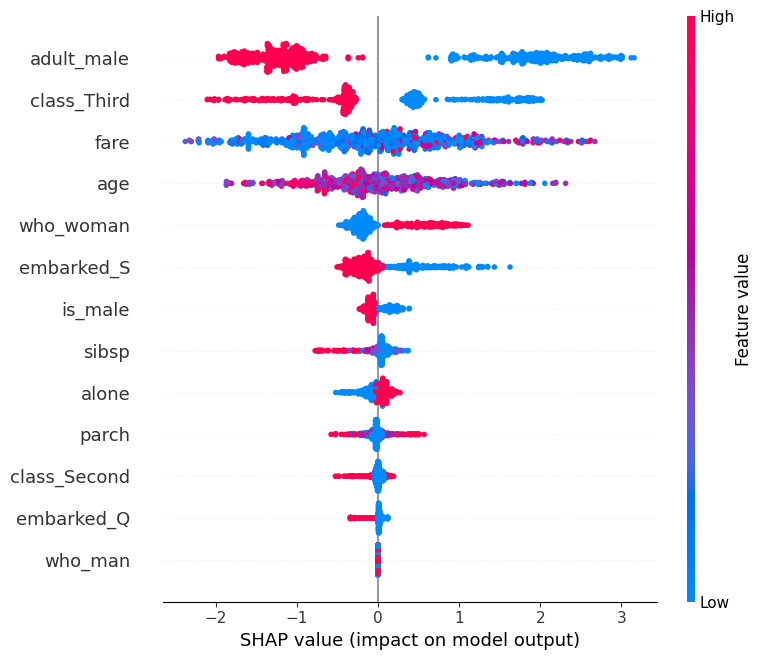

In [43]:
shap.summary_plot(shap_train, X_train)

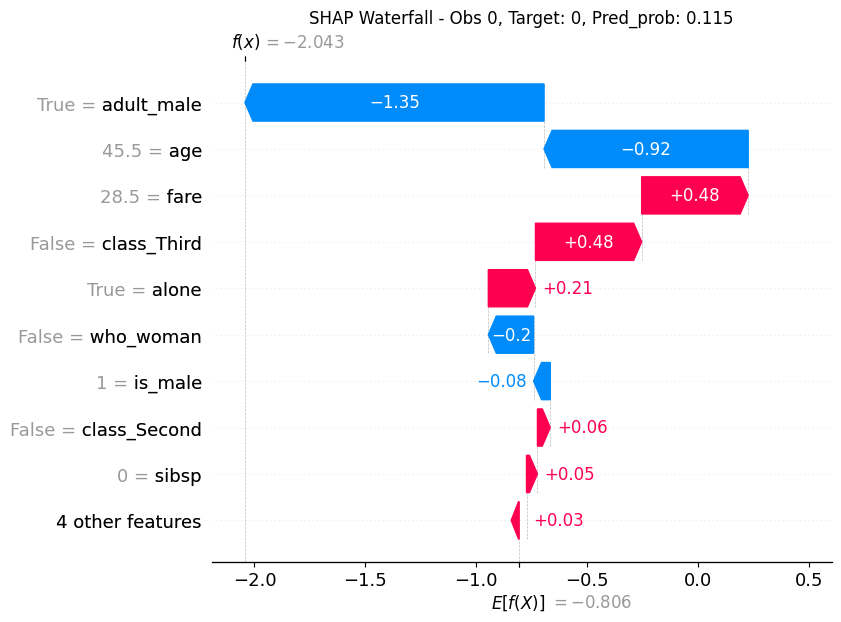

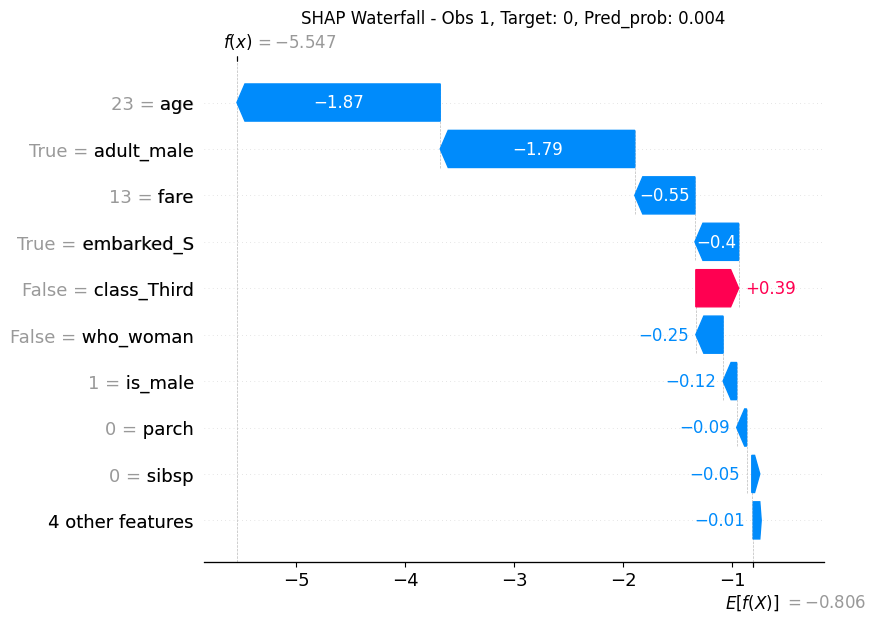

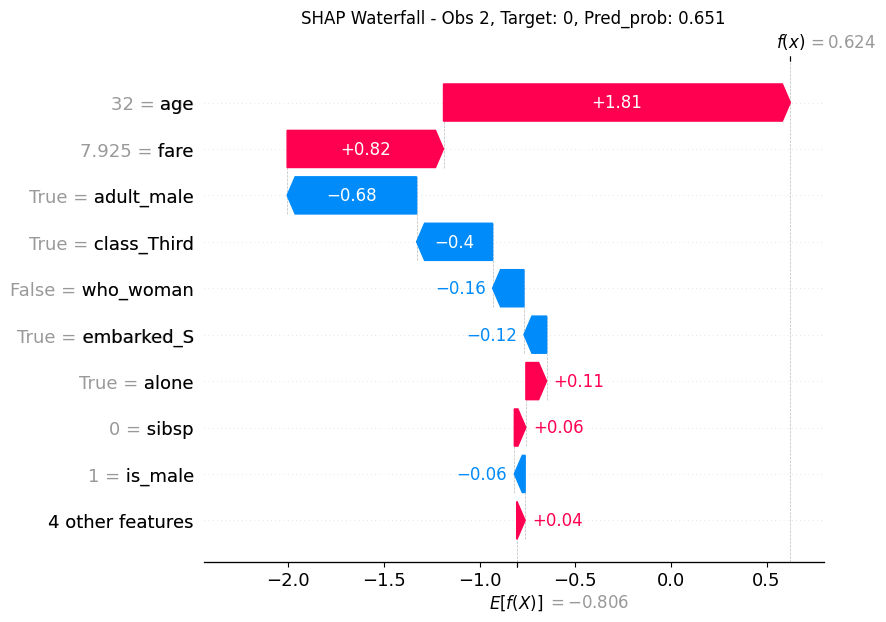

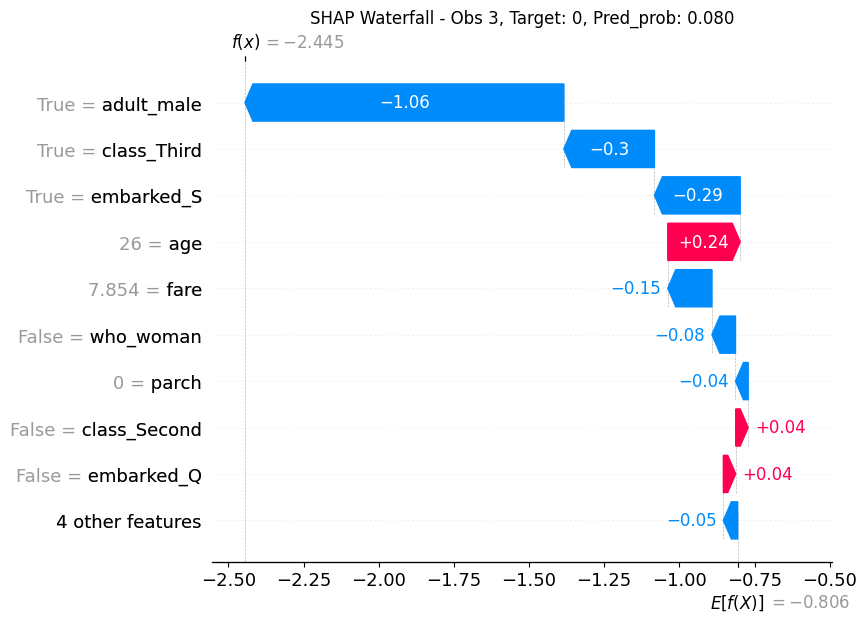

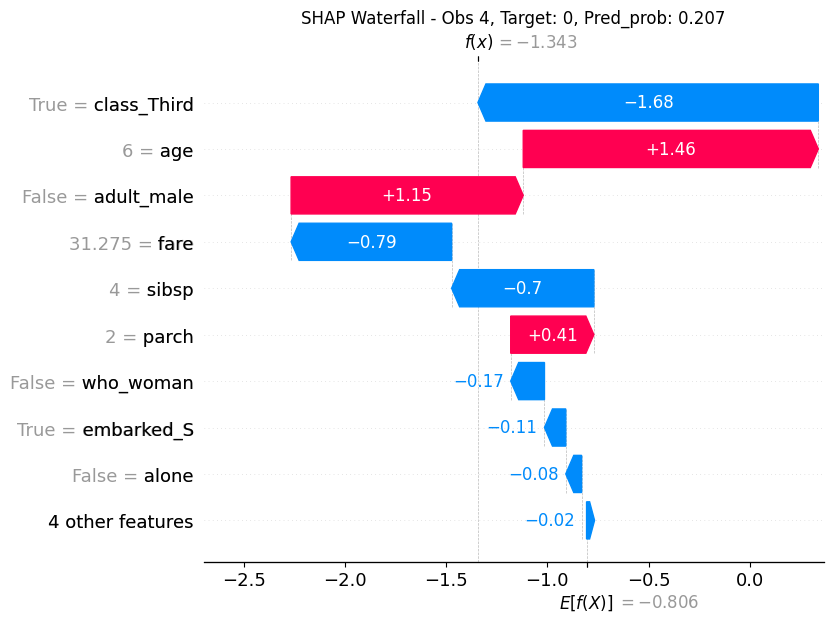

In [129]:
iidxes = y_train.reset_index(drop=True).loc[lambda x: x == 0].index[:5]
for i in iidxes:
    fig, ax = plt.subplots(figsize=(12, 6))
    shap.plots.waterfall(shap_train[i], show=False)
    ax.set_title(
        f"SHAP Waterfall - Obs {i}, Target: {y_train.iloc[i]}, Pred_prob: {lgbm.predict_proba(X_train.iloc[[i]])[0][1]:.3f}"
    )
    # plt.close()
    plt.show()

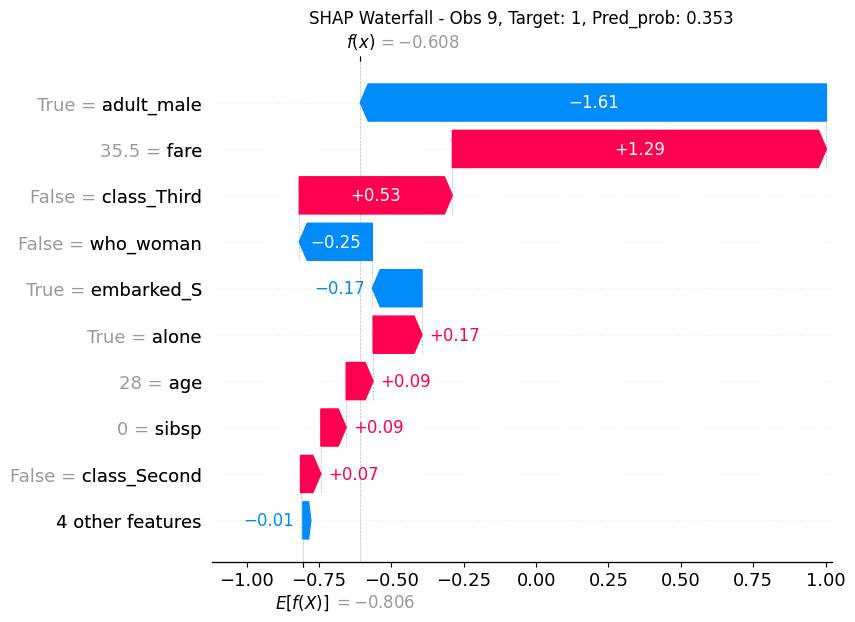

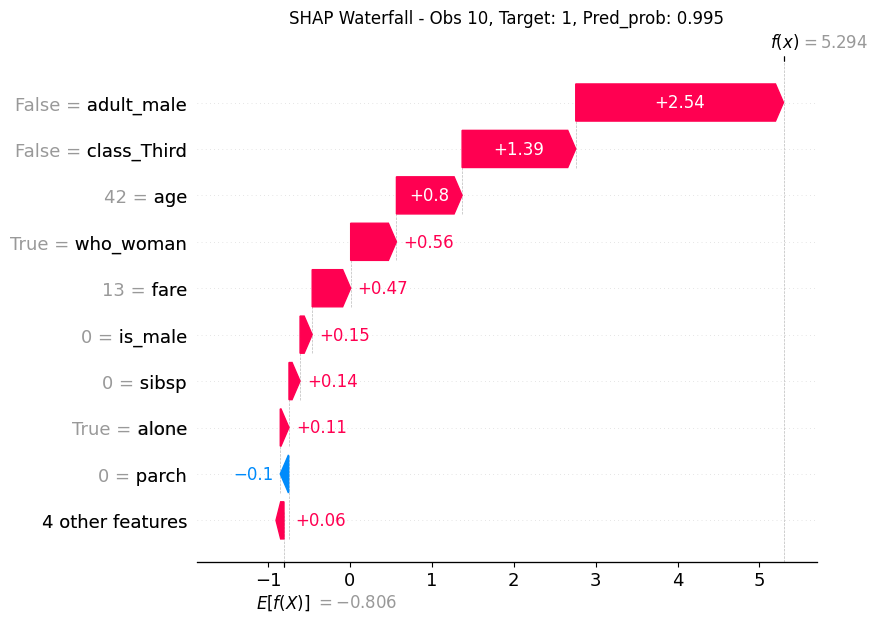

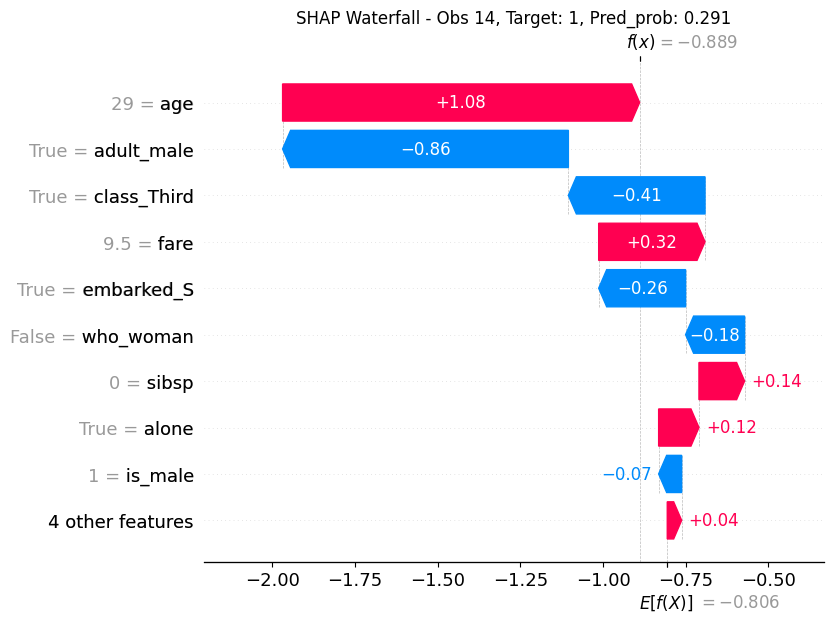

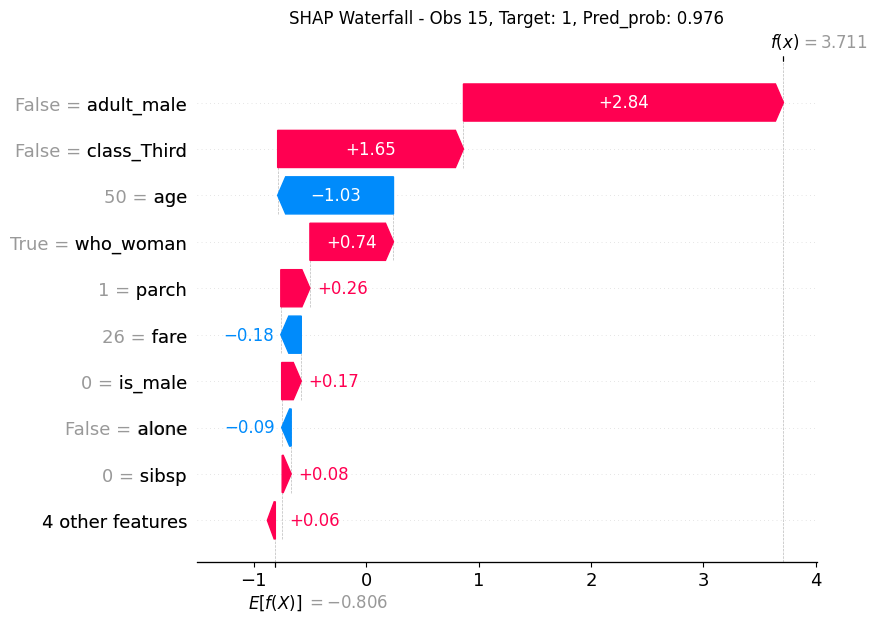

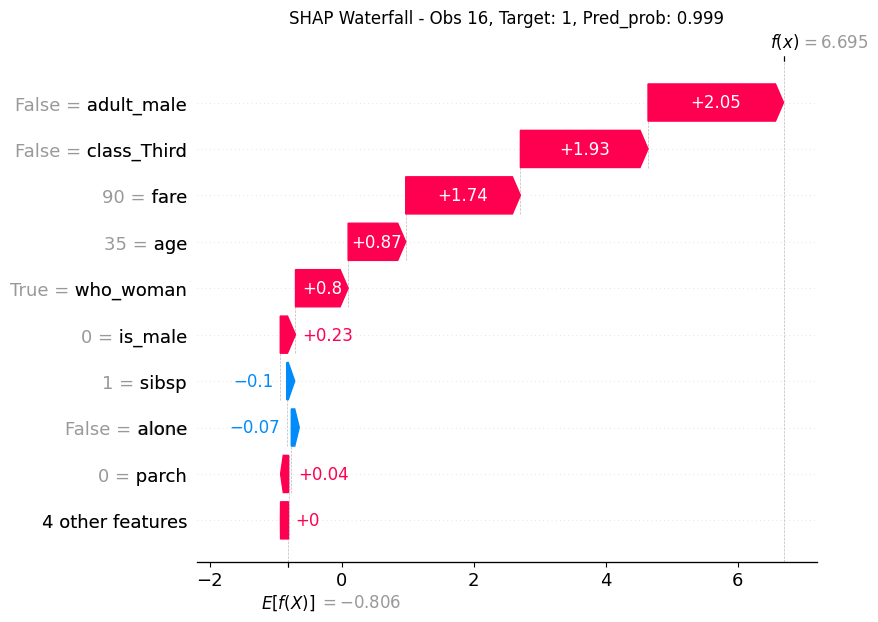

In [ ]:
iidxes = y_train.reset_index(drop=True).loc[lambda x: x == 1].index[:5]
for i in iidxes:
    fig, ax = plt.subplots(figsize=(12, 6))
    shap.plots.waterfall(shap_train[i], show=False)
    ax.set_title(
        f"SHAP Waterfall - Obs {i}, Target: {y_train.iloc[i]}, Pred_prob: {lgbm.predict_proba(X_train.iloc[[i]])[0][1]:.3f}"
    )
    # plt.close()
    plt.show()

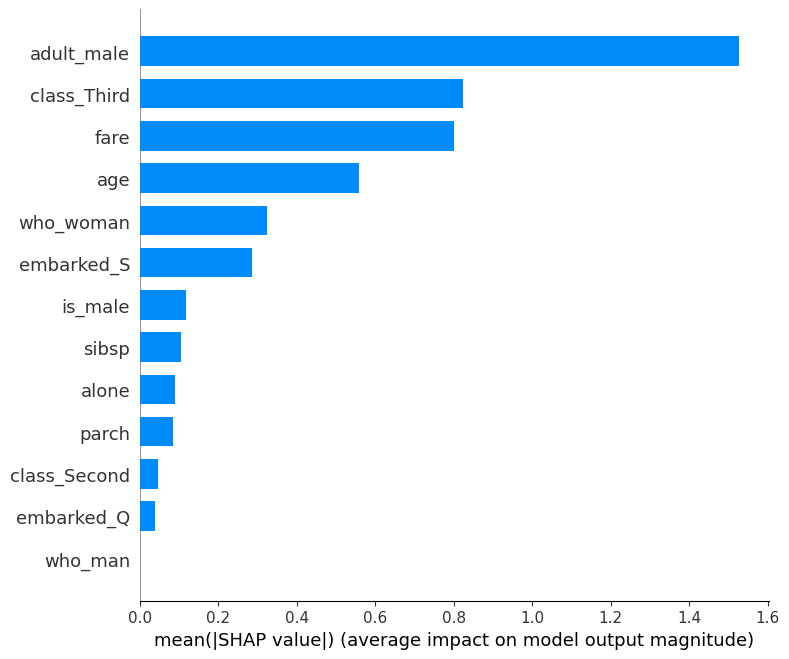

In [44]:
shap.summary_plot(shap_train, X_train, plot_type="bar")

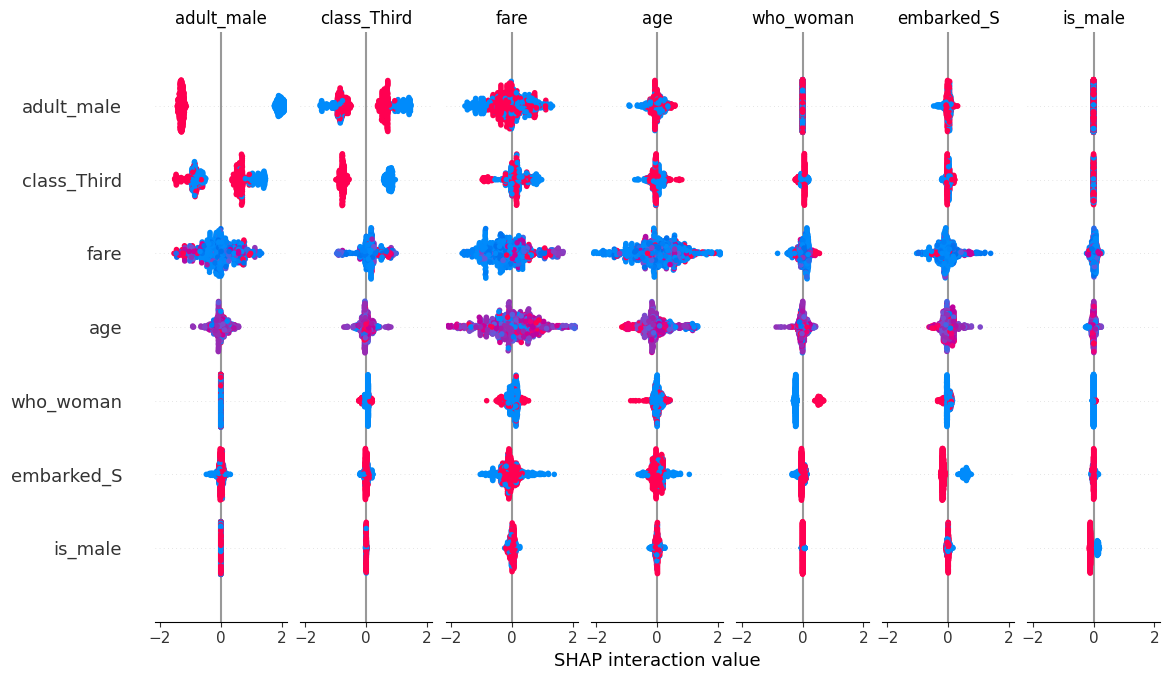

In [61]:
# 1. SHAP interaction values - most comprehensive
shap_interaction = explainer.shap_interaction_values(X_train)

# Plot interaction heatmap
shap.summary_plot(shap_interaction, X_train)

Text(0.5, 1.0, 'Feature Interaction Strength Matrix')

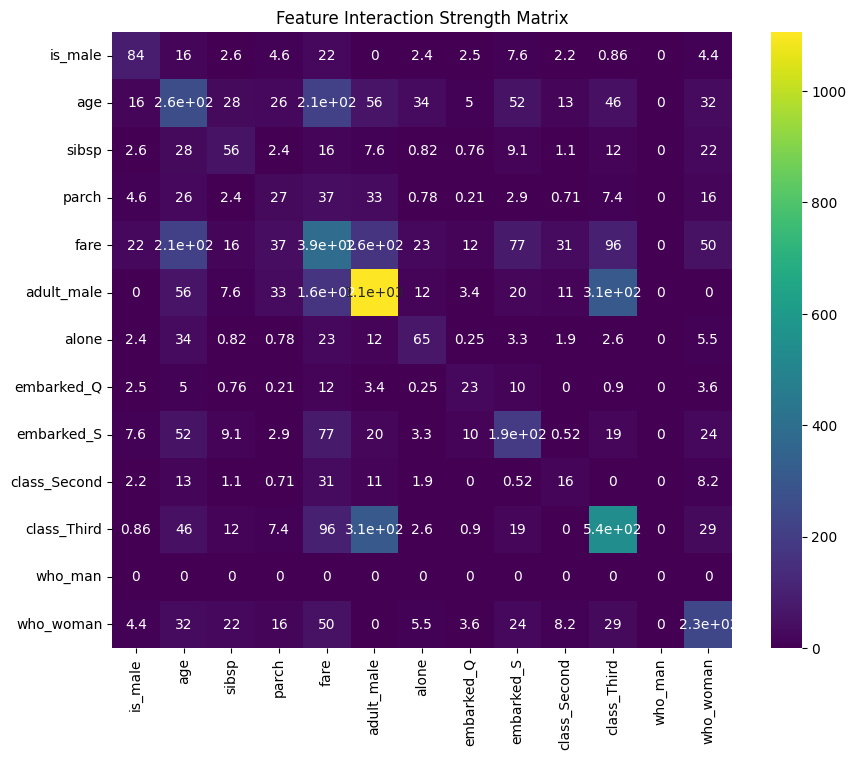

In [64]:
# 2. Feature interaction strength matrix
interaction_matrix = np.abs(shap_interaction).sum(0)
interaction_df = pd.DataFrame(
    interaction_matrix, index=X_train.columns, columns=X_train.columns
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_df, annot=True, cmap="viridis", ax=ax)
ax.set_title("Feature Interaction Strength Matrix")

In [63]:
# 3. Top interactions
# Get upper triangle of interaction matrix (avoid duplicates)
mask = np.triu(np.ones_like(interaction_matrix, dtype=bool), k=1)
interactions = []

for i in range(len(X_train.columns)):
    for j in range(i + 1, len(X_train.columns)):
        interactions.append(
            {
                "feature1": X_train.columns[i],
                "feature2": X_train.columns[j],
                "interaction_strength": interaction_matrix[i, j],
            }
        )

interaction_df = pd.DataFrame(interactions)
top_interactions = interaction_df.nlargest(10, "interaction_strength")
print("Top 10 Feature Interactions:")
print(top_interactions.to_string(index=False))

Top 10 Feature Interactions:
  feature1    feature2  interaction_strength
adult_male class_Third            305.022265
       age        fare            209.510034
      fare  adult_male            164.789660
      fare class_Third             96.015241
      fare  embarked_S             76.858681
       age  adult_male             56.276368
       age  embarked_S             52.440671
      fare   who_woman             50.499766
       age class_Third             45.805182
     parch        fare             37.224738


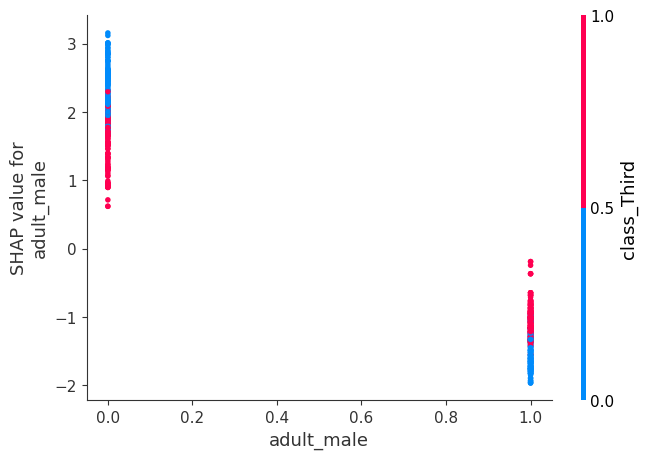

In [67]:
# 4. Visualize specific interactions
top_pair = top_interactions.iloc[0]
feature1, feature2 = top_pair["feature1"], top_pair["feature2"]

shap.dependence_plot(feature1, shap_train.values, X_train, interaction_index=feature2)

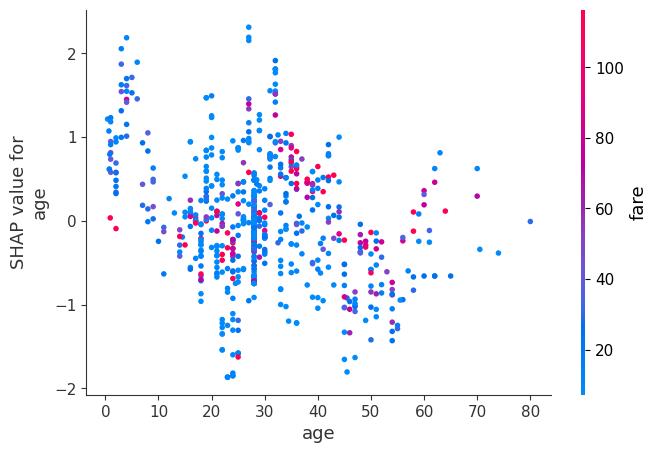

In [68]:
pair = top_interactions.iloc[1]
feature1, feature2 = pair["feature1"], pair["feature2"]

shap.dependence_plot(feature1, shap_train.values, X_train, interaction_index=feature2)

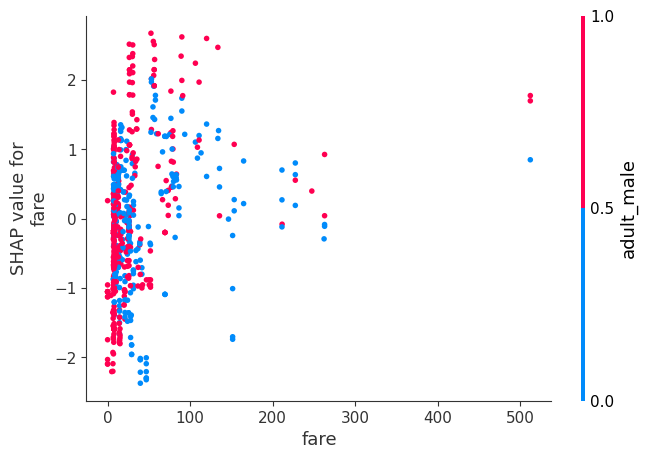

In [69]:
pair = top_interactions.iloc[2]
feature1, feature2 = pair["feature1"], pair["feature2"]

shap.dependence_plot(feature1, shap_train.values, X_train, interaction_index=feature2)

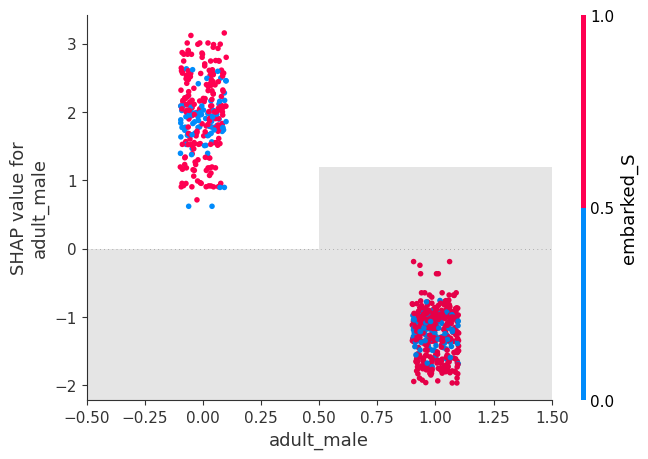

In [132]:
shap.plots.scatter(shap_train[:, "adult_male"], color=shap_train[:, "embarked_S"])

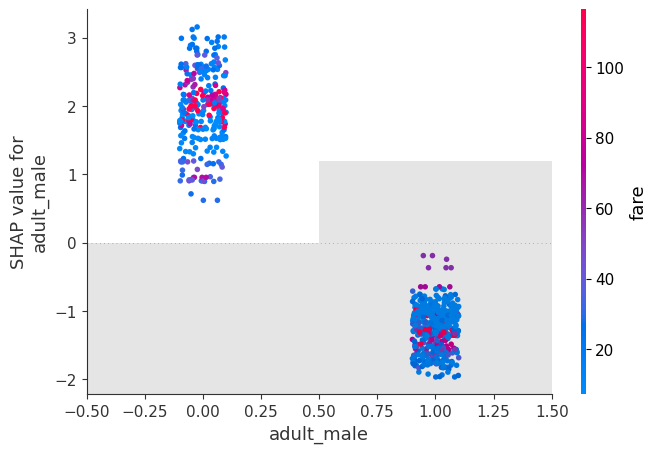

In [133]:
shap.plots.scatter(shap_train[:, "adult_male"], color=shap_train[:, "fare"])

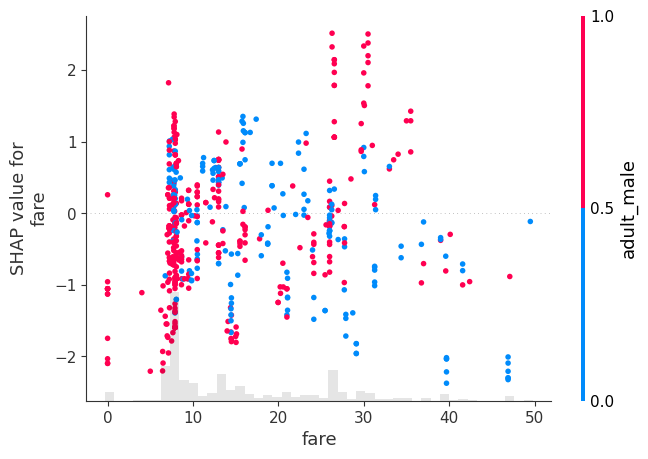

In [171]:
ff = lambda x: (x["fare"] < 50)
iidexs = np.where(ff(X_train))[0].tolist()
shap.plots.scatter(shap_train[iidexs, "fare"], color=shap_train[iidexs, "adult_male"])

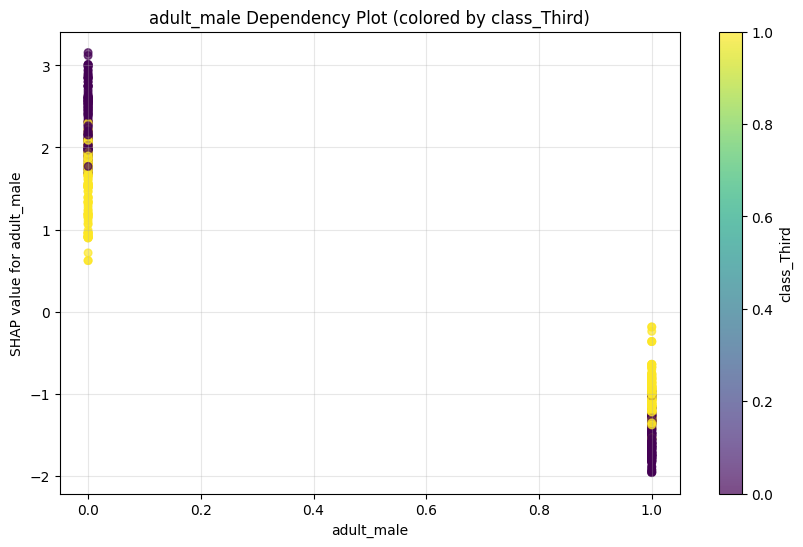

In [ ]:
#
adult_male_idx = list(X_train.columns).index("adult_male")
shap_values = shap_train.values[:, adult_male_idx]
adult_male_values = X_train["adult_male"].values
fare_values = X_train["class_Third"].values

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    adult_male_values, shap_values, c=fare_values, cmap="viridis", alpha=0.7, s=30
)
ax.set_xlabel("adult_male")
ax.set_ylabel("SHAP value for adult_male")
ax.set_title("adult_male Dependency Plot (colored by class_Third)")
fig.colorbar(scatter, ax=ax, label="class_Third")
ax.grid(True, alpha=0.3)

In [66]:
# 5. Alternative: sklearn's permutation-based interaction detection
from sklearn.inspection import permutation_importance

# Get feature importance
perm_importance = permutation_importance(
    lgbm, X_train, y_train, n_repeats=10, random_state=42
)

# Create interaction features manually and test
interaction_features = X_train.copy()
for i, col1 in enumerate(X_train.columns[:5]):  # Top 5 features
    for j, col2 in enumerate(X_train.columns[i + 1 : 6]):
        interaction_features[f"{col1}_x_{col2}"] = X_train[col1] * X_train[col2]

print(
    "Created interaction features:",
    [col for col in interaction_features.columns if "_x_" in col],
)

Created interaction features: ['is_male_x_age', 'is_male_x_sibsp', 'is_male_x_parch', 'is_male_x_fare', 'is_male_x_adult_male', 'age_x_sibsp', 'age_x_parch', 'age_x_fare', 'age_x_adult_male', 'sibsp_x_parch', 'sibsp_x_fare', 'sibsp_x_adult_male', 'parch_x_fare', 'parch_x_adult_male', 'fare_x_adult_male']


### misc